```
This software is part of GPU Ocean. 

Copyright (C) 2018, 2019 SINTEF Digital
Copyright (C) 2018, 2019 Norwegian Meteorological Institute

This notebook runs a performance benchmark for the CDKLM scheme using
several of the components for realistic simulations

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Numerical Order - nontrivial parameters


## Import modules and set up environment

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc, colors, cm
from matplotlib import pyplot as plt

import os
import datetime
import time
import gc
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

#Set large figure sizes
rc('figure', figsize=(6.0, 4.0))
rc('animation', html='html5')
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'


#Import our simulator
from SWESimulators import FBL, CTCS,KP07, CDKLM16, PlotHelper, Common, IPythonMagic
#Import initial condition and bathymetry generating functions:
from SWESimulators.BathymetryAndICs import *

In [2]:
%cuda_context_handler gpu_ctx

In [3]:
#Create output directory for images

#imgdir='images_convergence_' + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
#os.makedirs(imgdir)

imgdir = 'images_convergence_2019_11_06-10_53_52'

print("Saving images to " + imgdir)

Saving images to images_convergence_2019_11_06-10_53_52


In [4]:
def setBwStyles(ax):
    from cycler import cycler

    ax.set_prop_cycle( cycler('marker', ['.', 'x', 4, '+', '*', '1']) +
                       cycler('linestyle', ['-.', '--', ':', '-.', '--', ':']) +
                       #cycler('markersize', [15, 15, 15, 15, 15, 15]) +
                       cycler('color', ['k', 'k', 'k', 'k', 'k', 'k']) )

8.092556560821178 -6.541861464796368


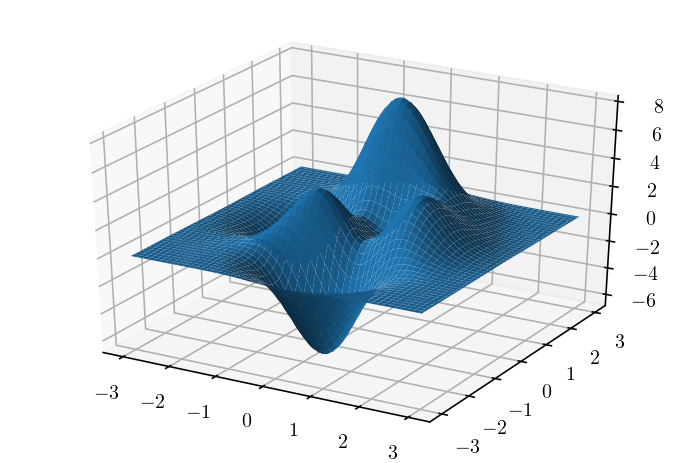

In [5]:
def peaks(nx, ny):
    x = np.linspace(-3, 3, nx)
    y = np.linspace(-3, 3, ny)
    x, y = np.meshgrid(x, y)
    z = 3*(1-x)**2*np.exp(-(x**2) - (y+1)**2) - 10*(x/5-x**3-y**5)*np.exp(-x**2-y**2)-1/3*np.exp(-(x+1)**2-y**2)
    return x, y, z


from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y, z = peaks(100, 100)
ax.plot_surface(x, y, z)

print(np.max(z), np.min(z))

In [6]:
width = 500000
height = 500000

domain_min = 16
#domain_max = 8192*2
domain_max = 4096

    
g = 9.81
r = 0.00
f = 1.0e-4
beta = 1.0e-11

end_time = 1600.0

In [7]:
def averageFV(highres_solution, factor):
    NX = highres_solution.shape[1]
    NY = highres_solution.shape[0]
    
    assert(NY % factor == 0)
    assert(NX % factor == 0)
    
    nx = int(NX / factor)
    ny = int(NY / factor)
    
    factor = int(factor)
    
    return  highres_solution.reshape([ny, factor, nx, factor]).mean(3).mean(1)


def averageFD(highres_solution, factor):
    target = highres_solution.shape[0] / factor
    while (highres_solution.shape[0] > target):
        highres_solution = highres_solution[::2, ::2]
    return highres_solution

FV: Max=0.93095, min=0.00000, sum=0.0840758905
FV: Max=0.98230, min=0.00000, sum=0.0840758905
FV: Max=0.99555, min=0.00000, sum=0.0840758830
FV: Max=0.99889, min=0.00000, sum=0.0840758905
FV: Max=0.99973, min=0.00000, sum=0.0840758899
Angle: Max=0.98279, min=-0.46365, sum=0.2412161509
Angle: Max=0.98279, min=-0.46365, sum=0.2416571482
Angle: Max=0.98279, min=-0.46365, sum=0.2418540942
Angle: Max=0.98279, min=-0.46365, sum=0.2419472423
Angle: Max=0.98279, min=-0.46365, sum=0.2419925496


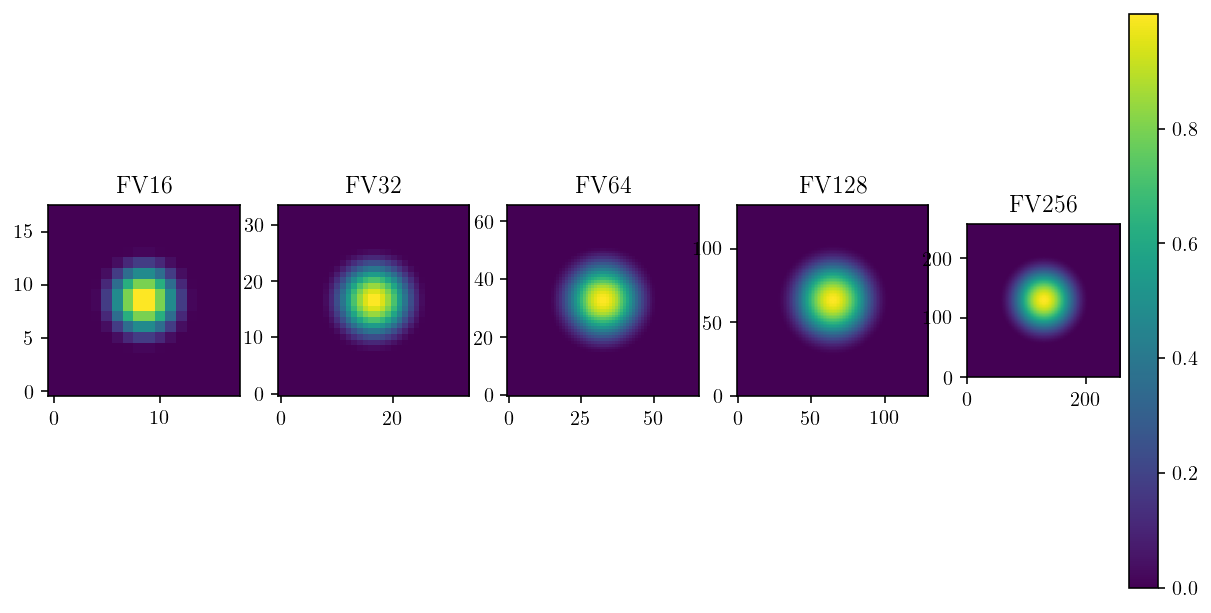

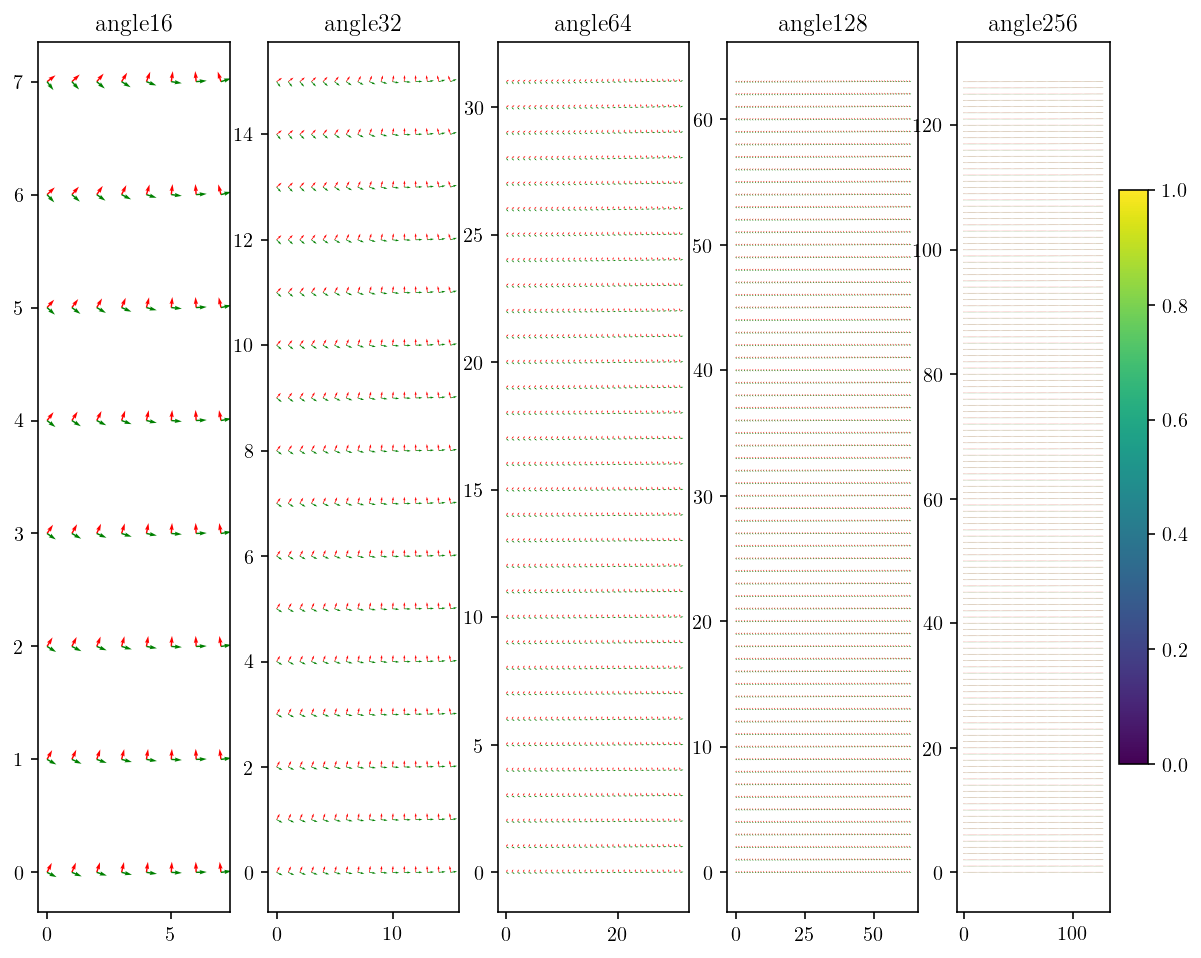

In [8]:
def initH(h0, ghosts, reference_domain_size):    
    ref_nx = reference_domain_size
    ref_ny = reference_domain_size
    nx = h0.shape[1] - ghosts[0] - ghosts[2]
    ny = h0.shape[0] - ghosts[1] - ghosts[3]
    
    _, _, z = peaks(ref_nx, ref_ny)
    z = averageFD(z, ref_nx/nx)
    h0.fill(100.0)
    x0, x1 = ghosts[0], nx+ghosts[0]
    y0, y1 = ghosts[1], ny+ghosts[1]
    h0[y0:y1, x0:x1] = h0[y0:y1, x0:x1] + z*10
    
    return h0
    
x = np.zeros((8, 8))
initH(x, [0, 0, 0, 0], 64)
    
def initAngle(angle):
    ny, nx = angle.shape
    
    #North pole
    x0 = 0.5
    y0 = 2.0
    
    #Vector to north
    x = np.linspace(-1, 1, nx) - x0
    y = np.linspace(-1, 1, ny) - y0
    x, y = np.meshgrid(x, y)
    
    #Normalize
    l = np.sqrt(x**2 + y**2)
    x = x/l
    y = y/l
    
    angle.fill(-np.pi/2)
    angle = angle + np.arccos(x)
    
    return angle
    
    
def initEtaFV(eta0, ghosts, reference_domain_size):
    ref_nx = reference_domain_size
    ref_ny = reference_domain_size
    nx = eta0.shape[1] - ghosts[0] - ghosts[2]
    ny = eta0.shape[0] - ghosts[1] - ghosts[3]
    
    def my_cos(i, j):
        size = 0.6
        x = 2*(i + 0.5 - ref_nx/2.0) / float(ref_nx)
        y = 2*(j + 0.5 - ref_ny/2.0) / float(ref_ny)
        r = np.sqrt(x**2 + y**2)
        return (1.0 + np.cos(np.pi*r/size)) * (r < size)
    
    #Generate disturbance 
    disturbance = np.fromfunction(lambda i, j: my_cos(i,j), (ref_ny, ref_nx))
    disturbance = averageFV(disturbance, ref_nx/nx) 
    
    eta0.fill(0.0)
    x0, x1 = ghosts[0], nx+ghosts[0]
    y0, y1 = ghosts[1], ny+ghosts[1]
    eta0[y0:y1, x0:x1] += (0.5*disturbance)
    
    #Make sure solution is symmetric
    eta0 = 0.5*(eta0 +  eta0[::-1, ::-1])
    

    
def initHU(hu0, ghosts):
    hu0.fill(0.0)
    
def initHV(hv0, ghosts):
    hv0.fill(0.0)

def testInitDataFV(domain_size, reference_domain_size):
    nx = domain_size
    ny = domain_size
    ghosts = [1, 1, 1, 1] 
    dataShape = (ny + ghosts[1]+ghosts[3], 
                 nx + ghosts[0]+ghosts[2])
    eta0 = np.zeros(dataShape, dtype=np.float32);
    initEtaFV(eta0, ghosts, reference_domain_size)
    return eta0#[ghosts[1]:eta0.shape[1]+ghosts[1], ghosts[0]:eta0.shape[0]+ghosts[0]]
     
#def testInitDataFD(domain_size, reference_domain_size):
#    nx = domain_size
#    ny = domain_size
#    ghosts = [1, 1, 1, 1] 
#    dataShape = (ny + ghosts[1]+ghosts[3], 
#                 nx + ghosts[0]+ghosts[2])
#    h0 = np.zeros(dataShape, dtype=np.float32);
#    initH(h0, ghosts, reference_domain_size)
#    return h0#[ghosts[1]:eta0.shape[1]+ghosts[1], ghosts[0]:eta0.shape[0]+ghosts[0]]
    
plt.figure(figsize=(12,8))
for i in range(5):
    domain_size = domain_min*2**i
    eta0 = testInitDataFV(domain_size, domain_min*2**6)
    plt.subplot(1, 6, i+1)
    plt.imshow(eta0, interpolation='nearest', origin='lower')
    plt.title("FV"+str(domain_size))
    print("FV: Max={:.05f}, min={:.05f}, sum={:.010f}".format(np.max(eta0), np.min(eta0), np.sum(eta0/(domain_size*domain_size))))
plt.colorbar()
    
#plt.figure(figsize=(12,8))
#for i in range(5):
#    domain_size = domain_min*2**i
#    h0 = testInitDataFD(domain_size, domain_min*2**6)
#    plt.subplot(1, 6, i+1)
#    plt.imshow(h0, interpolation='nearest', origin='lower')
#    plt.title("FD"+str(domain_size))
#    print("FD: Max={:.05f}, min={:.05f}, sum={:.010f}".format(np.max(h0), np.min(h0), np.sum(h0/(domain_size*domain_size))))
#plt.colorbar()
    
    
plt.figure(figsize=(12,8))
for i in range(5):
    domain_size = domain_min*2**i
    angle = np.empty((domain_size, domain_size))
    angle = initAngle(angle)
    plt.subplot(1, 6, i+1)
    #plt.imshow(angle, interpolation='nearest', origin='lower')
    #plt.contour(angle, colors='k', alpha=0.2, linewidths=0.8)
    plt.quiver(np.sin(angle[::2, ::2]), np.cos(angle[::2, ::2]), color='r')
    plt.quiver(np.cos(angle[::2, ::2]), -np.sin(angle[::2, ::2]), color='g')
    plt.title("angle"+str(domain_size))
    print("Angle: Max={:.05f}, min={:.05f}, sum={:.010f}".format(np.max(angle), np.min(angle), np.sum(angle/(domain_size*domain_size))))
plt.colorbar()
    

    

In [9]:
def plotData(eta0, u0, v0, eta1, u1, v1):
    fig, axarr = plt.subplots(2, 3, figsize=(12, 8))
    axarr[0, 0].imshow(eta0, interpolation="nearest")
    axarr[0, 1].imshow(u0, interpolation="nearest")
    axarr[0, 2].imshow(v0, interpolation="nearest")
    axarr[1, 0].imshow(eta1, interpolation="nearest")
    axarr[1, 1].imshow(u1, interpolation="nearest")
    axarr[1, 2].imshow(v1, interpolation="nearest")
    print("Eta0: Maximum = {:.05f}, minimum = {:.05f}".format(np.max(eta0), np.min(eta0)))
    print("Eta1: Maximum = {:.05f}, minimum = {:.05f}".format(np.max(eta1), np.min(eta1)))

## CDKLM 16

In [10]:
def benchmarkCDKLM(cdklm_filename, plot=False):
    
    def runCDKLM(domain_size, reference_domain_size):
        #Clean up old simulator if any:
        if 'cdklm_sim' in globals():
            cdklm_sim.cleanUp()

        nx = domain_size
        ny = domain_size

        dx = float(width/nx)
        dy = float(height/ny)

        ghosts = np.array([2,2,2,2])
        dataShape = (ny + ghosts[1]+ghosts[3], 
                     nx + ghosts[0]+ghosts[2])

        Hi = np.zeros((dataShape[0]+1, dataShape[1]+1), dtype=np.float32)
        eta0 = np.zeros(dataShape, dtype=np.float32);
        hu0 = np.zeros(dataShape, dtype=np.float32);
        hv0 = np.zeros(dataShape, dtype=np.float32);
        angle = np.zeros(dataShape, dtype=np.float32);
        
        dt = end_time / domain_size
        initH(Hi, ghosts, reference_domain_size+1)
        initEtaFV(eta0, ghosts, reference_domain_size)
        initHU(hu0, ghosts)
        initHV(hv0, ghosts)
        initAngle(angle)

        #Initialize simulator
        cdklm_sim = CDKLM16.CDKLM16(gpu_ctx, 
                      eta0, hu0, hv0, Hi, 
                      nx, ny, 
                      dx, dy, dt, 
                      g, f, r, coriolis_beta=beta,
                      angle=angle)
        pre_sim = time.time()
        t = cdklm_sim.step(end_time)
        gpu_ctx.synchronize()
        post_sim = time.time()
        eta1, hu1, hv1 = cdklm_sim.download()
        post_dl = time.time()
        Hi, Hm = cdklm_sim.downloadBathymetry()
        t_sim = post_sim-pre_sim
        t_dl = post_dl-post_sim
        print("Domain size={:d}, t={:f}, nt={}, eta=[{:f}, {:f}], Hi=[{:f}, {:f}], T_sim={:f}, T_dl={:f}".format(
            domain_size, t, cdklm_sim.num_iterations, np.min(eta1), np.max(eta1), np.min(Hi), np.max(Hi), t_sim, t_dl
        ))

        
        if (plot==True):
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.view_init(25, 45)
            ax.pbaspect = [2.0, 2.0, 0.25]
            x = np.linspace(0, nx*dx, nx)
            y = np.linspace(0, ny*dy, ny)
            x, y = np.meshgrid(x, y)
            
            ls = colors.LightSource(270, 5)
            
            eps = 0.0
            
            ax.plot_surface(x, y, eta1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], cmap=cm.gist_ncar, edgecolor=None, shade=True, alpha=0.7, vmin=0, vmax=0.7, lightsource=ls)
            ax.contour(x, y, eta1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]]+eps, colors='k', levels=np.linspace(-1.0, 1.0, 20)+eps)
            
            ax.plot_surface(x, y, -Hm[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], cmap=cm.gist_earth, edgecolor=None, shade=True, alpha=0.9, lightsource=ls)
            ax.contour(x, y, -Hm[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]]+eps, colors='k', levels=np.linspace(-180, -40, 14)+eps)

        return [t_sim, t_dl]
        #return [eta0, hu0, hv0, eta1, hu1, hv1]


    #Run all domain sizes 
    data = {'domain_size': [], 't_dl': [], 't_sim': []};
    domain_size = domain_min
    
    reference_domain_size = domain_min
    while (reference_domain_size <= domain_max):
        reference_domain_size *= 2
        
    while (domain_size <= domain_max):
        t_sim, t_dl = runCDKLM(domain_size, reference_domain_size)
        data['domain_size'] += [domain_size]
        data['t_sim'] += [t_sim]
        data['t_dl'] += [t_dl]
        domain_size = domain_size*2

    #Save to file
    np.savez_compressed(cdklm_filename, **data)
    
    
cdklm_filename = imgdir + "/CDKLM_data.npz"
benchmarkCDKLM(cdklm_filename)

Domain size=16, t=1600.000000, nt=16, eta=[-0.000004, 0.420820], Hi=[38.134552, 179.966202], T_sim=0.003945, T_dl=0.000191
Domain size=32, t=1600.000000, nt=32, eta=[-0.000004, 0.460297], Hi=[35.098377, 179.966202], T_sim=0.007589, T_dl=0.000190
Domain size=64, t=1600.000000, nt=64, eta=[-0.000005, 0.467454], Hi=[34.842125, 181.030853], T_sim=0.015656, T_dl=0.000215
Domain size=128, t=1600.000000, nt=128, eta=[-0.000005, 0.469685], Hi=[34.528316, 181.030853], T_sim=0.030541, T_dl=0.000257
Domain size=256, t=1600.000000, nt=256, eta=[-0.000011, 0.470274], Hi=[34.500393, 181.034698], T_sim=0.069798, T_dl=0.000393
Domain size=512, t=1600.000000, nt=512, eta=[-0.000011, 0.470431], Hi=[34.492626, 181.061584], T_sim=0.499943, T_dl=0.000923
Domain size=1024, t=1600.000000, nt=1024, eta=[-0.000011, 0.470474], Hi=[34.489544, 181.061584], T_sim=3.503044, T_dl=0.002146
Domain size=2048, t=1600.000000, nt=2048, eta=[-0.000012, 0.470480], Hi=[34.488705, 181.062042], T_sim=27.600917, T_dl=0.018379
D

[  32   64  128  256  512 1024 2048 4096]
[1.92384406 2.06308514 1.95070658 2.28538084 7.16268894 7.00688727
 7.8791229  8.09735708]
[0.99500624 1.12923463 1.19666667 1.53203343 2.34545455 2.3255814
 8.56522222 5.22592655]


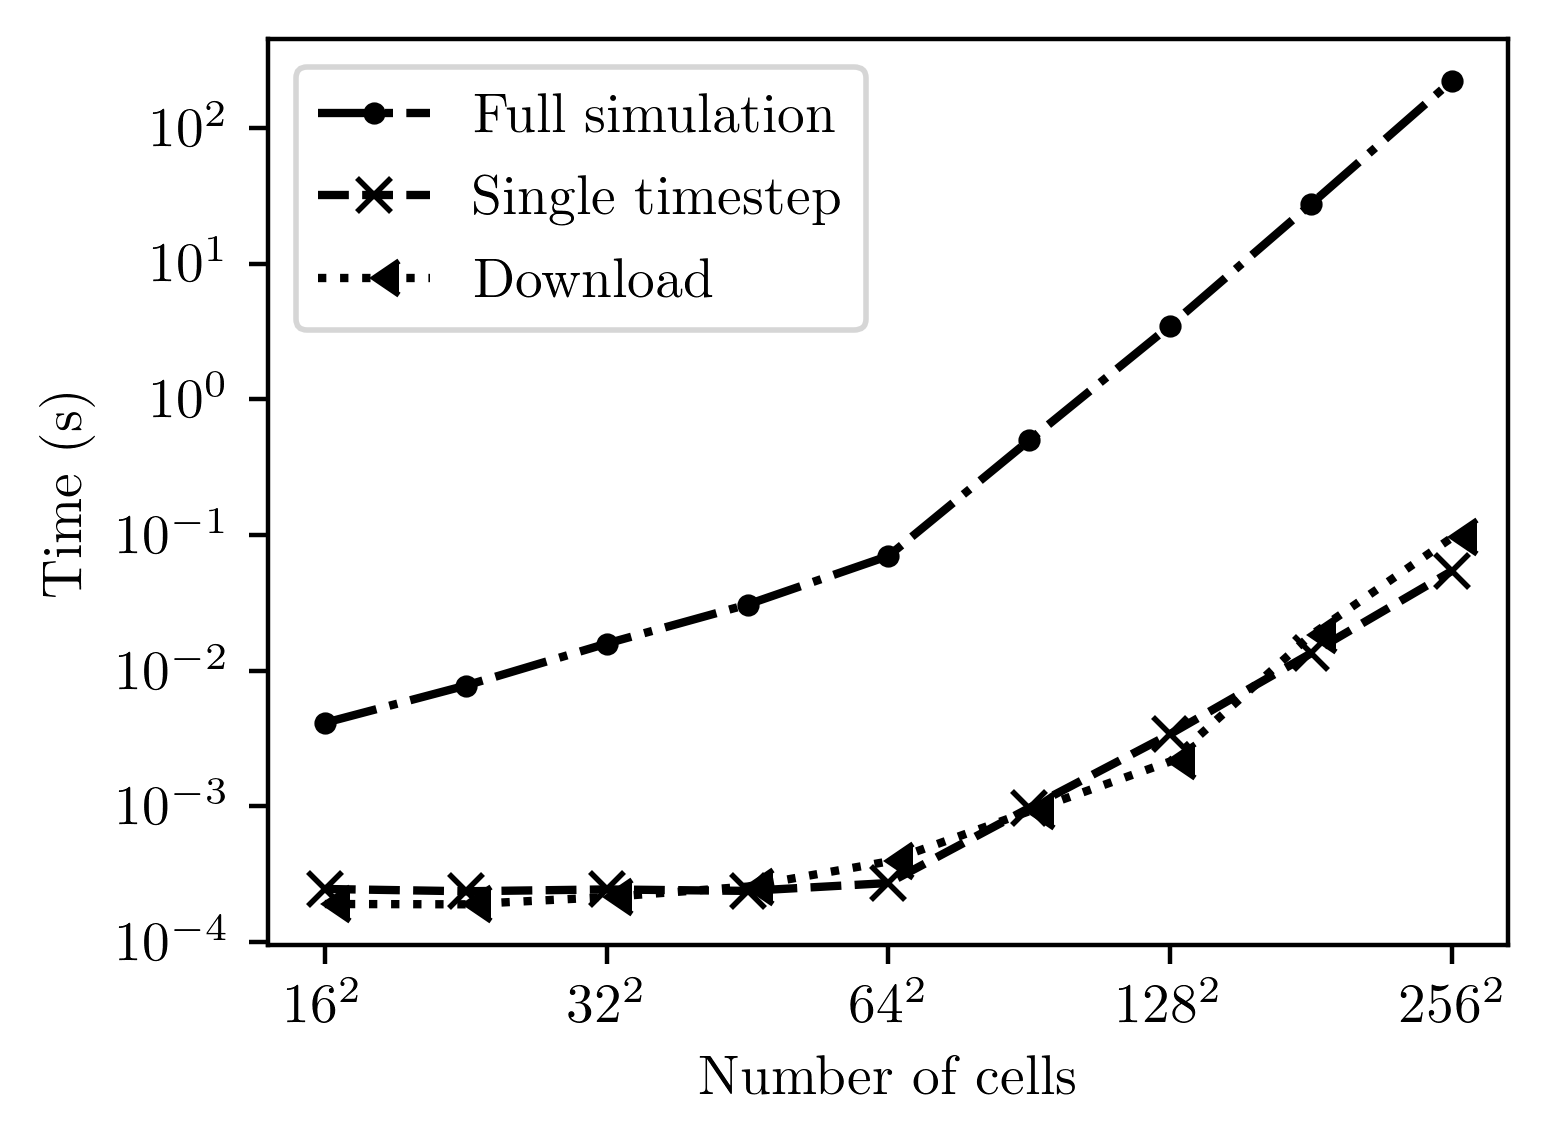

In [11]:

cdklm_filename = imgdir + "/CDKLM_data.npz"


with np.load(cdklm_filename) as npzfile:
    #Get all domain sizes in file
    domain_size = npzfile['domain_size']
    t_sim = npzfile['t_sim']
    t_dl = npzfile['t_dl']
    
    begin = 0
    domain_size = domain_size[begin:]
    t_sim = t_sim[begin:]
    t_dl = t_dl[begin:]
    
    x = domain_size * domain_size
    cells = x * domain_size #nx*ny*nt
    fig = plt.figure(figsize=(4, 3), dpi=200)
    setBwStyles(fig.gca())
    plt.loglog(x, t_sim+t_dl, label='Full simulation')
    plt.loglog(x, t_sim/domain_size, label='Single timestep')
    plt.loglog(x, t_dl, label='Download')
    #plt.loglog(x, t_dl+t_sim, 'gx-',)
    plt.xlabel('Number of cells')
    
    x = x[::2]
    plt.xticks(x, ["$" + str(s) + "^2$" for s in domain_size])
    plt.minorticks_off()
    plt.ylabel('Time (s)')
    plt.legend()
    plt.savefig(imgdir + '/performance.pdf', bbox_inches = "tight")
    
    print(domain_size[1:])
    print(t_sim[1:] / t_sim[:-1])
    print(t_dl[1:] / t_dl[:-1])

In [12]:
print(imgdir)

images_convergence_2019_11_06-10_53_52
